In [1]:
import os
import numpy as np
import glob
import pickle
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from __future__ import division # make py2 act like py3 where int division turns into float

import utils

In [2]:

# simple class to update limits as you go through iterations of data
# first call update_lims(first_lims)
# then update_lims.update(new_lims)
# update_lims.output() outputs lims
class update_lims:
    
    def __init__(self, lims):
        self.lims = lims
        
    
    def update(self, new_lims):
        if self.lims[0] > new_lims[0]:
            self.lims[0] = new_lims[0]
        
        if self.lims[1] < new_lims[1]:
            self.lims[1] = new_lims[1]

    def output(self):
        return self.lims
    
    
# find 2D subplot index based on a numerical incremented index (ie. idx=3 would be (2,1) for a 2x2 subplot figure)     
def subplot_loc(idx, num_rows, num_col):
    if n_rows == 1:
        subplot_index = idx
    else:
        subplot_index = np.unravel_index(idx_cond, (n_rows, int(n_columns))) # turn int index to a tuple of array coordinates
    return subplot_index

In [3]:
# declare some fixed constant variables
axis_label_size = 15

In [4]:
"""

User-defined variables

"""

# indicate a file to analyze
fname = 'vj_ofc_imageactivate_02_200_006' # 'VJ_OFCVTA_7_260_D6' # 
fdir = r'D:\vj_ofc_imageactivate_02_200\vj_ofc_imageactivate_02_200_006' # r'C:\2pData\Vijay data\VJ_OFCVTA_7_D8_trained' #   

# set the sampling rate
fs = 30

# trial windowing 
trial_start_end_sec = np.array([-5.5, 8]) # trial windowing in seconds relative to ttl-onset/trial-onset, in seconds
baseline_start_end_sec = np.array([trial_start_end_sec[0], -0.2])
event_dur = 2 # duration of stim/event in seconds

# analysis and plotting arguments
flag_npil_corr = True # declare which data to load in
flag_zscore = True # whether or not to z-score data for plots
flag_sort_rois = False
if flag_sort_rois:
    user_sort_method = 'max_value' # peak_time or max_value
    roi_sort_cond = 'slm_stim'  
flag_roi_trial_avg_errbar = True
flag_trial_avg_errbar = True

In [5]:
if flag_npil_corr == True:
    signals_fpath = os.path.join(fdir, "{}_neuropil_corrected_signals*".format(fname))
    
elif flag_npil_corr == False:
    signals_fpath = os.path.join(fdir, "*_extractedsignals*")

save_path = os.path.join(fdir, 'event_rel_analysis_' + fname)

utils.check_exist_dir(save_path) # make the save directory

'D:\\vj_ofc_imageactivate_02_200\\vj_ofc_imageactivate_02_200_006\\event_rel_analysis_vj_ofc_imageactivate_02_200_006'

In [6]:
# convert times to samples and get sample_vector
trial_begEnd_samp = trial_start_end_sec*fs # turn trial start/end times to samples
trial_svec = np.arange(trial_begEnd_samp[0], trial_begEnd_samp[1])
baseline_begEnd_samp = baseline_start_end_sec*fs
baseline_svec = (np.arange(baseline_begEnd_samp[0], baseline_begEnd_samp[1]+1, 1) - baseline_begEnd_samp[0]).astype('int')

num_samples_trial = len( trial_svec )
tvec = np.round(np.linspace(trial_start_end_sec[0], trial_start_end_sec[1], num_samples_trial+1), 2)

t0_sample = utils.get_tvec_sample(tvec, 0) # grabs the sample index of a given time from a vector of times
event_bound_ratio = [(t0_sample-1)/num_samples_trial , (t0_sample+event_dur*fs+1)/num_samples_trial] # fraction of total samples for event start and end; only used for plotting line indicating event duration

x_tick_indices = range(len(tvec))

In [7]:
# load time-series data
glob_signal_files = glob.glob(signals_fpath)
if len(glob_signal_files) == 1:
    signals = np.squeeze(np.load(glob_signal_files[0]))
else:
    print('Warning: No or multiple signal files detected; using first detected file')

num_rois = signals.shape[0]
    
#load behavioral data and trial info
try:
    glob_frame_files = glob.glob(os.path.join(fdir, "framenumberforevents_{}*".format(fname))) # look for a file in specified directory
    event_frames = pickle.load( open( glob_frame_files[0], "rb" ) ) # latin1 b/c original pickle made in python 2

except:
    print('Cannot find behavioral data file or file path is incorrect; utils.extract_trial_data will throw error.')
    
all_conditions = event_frames.keys()
conditions = [ all_conditions[i] for i in [0] ] # __ USER DEFINE ; for vijay: [0, 4, 6]
conditions

['slm_stim']

In [8]:
# extract trial data
data_dict = utils.extract_trial_data(signals, trial_begEnd_samp, event_frames, 
                                     conditions, baseline_start_end_samp = baseline_begEnd_samp)

In [9]:
# calculate all the color limits for heatmaps; useful for locking color limits across different heatmap subplots

# for trial_avg data, get min/max across conditions
clims_data = [ np.nanmin( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ), 
        np.nanmax( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ) ]

# for z-scored data, we'd like for the color scale to be centered at 0; first we get color limits
tmp_clim = [ np.nanmin( [data_dict[key]['ztrial_avg_data'] for key in data_dict] ), 
        np.nanmax( [data_dict[key]['ztrial_avg_data'] for key in data_dict] ) ]
# then we take the higher of the two magnitudes
clims_max = np.max(np.abs(tmp_clim))
# and set it as the negative and positive limit for plotting
clims_z = [-clims_max*0.3, clims_max*0.3]

## Plot trial-resolved heatmap for each ROI

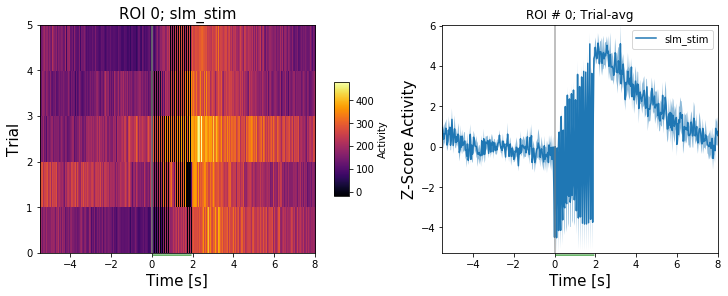

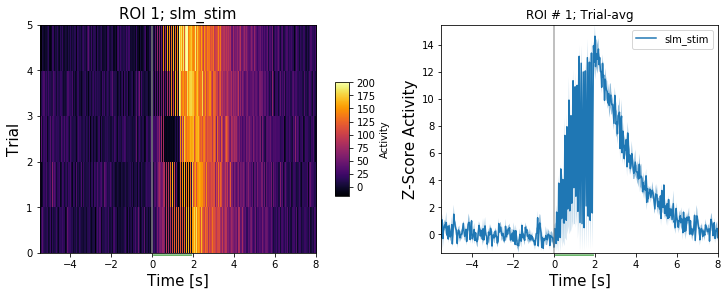

In [10]:
num_subplots = len(conditions) + 1 # plus one for trial-avg traces
n_columns = np.min([num_subplots, 4.0])
n_rows = int(np.ceil(num_subplots/n_columns))

for iROI in range(2):
 
    roi_clims = [ np.nanmin( [np.nanmin(data_dict[cond]['data'][...,iROI,:]) for cond in conditions] ), 
        np.nanmax( [np.nanmax(data_dict[cond]['data'][...,iROI,:]) for cond in conditions] ) ]
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=int(n_columns), 
                           figsize = (n_columns*5, n_rows*4),
                           constrained_layout=True)
    
    for idx_cond, cond in enumerate(conditions):
        
        # set imshow extent to replace x and y axis ticks/labels
        plot_extent = [tvec[0], tvec[-1], 0, data_dict[cond]['num_trials']]
        
        # determine subplot location index
        subplot_index = subplot_loc(idx_cond, n_rows, n_columns)
        
        # plot x and y labels for first subplot
        if subplot_index == (0, 0) or subplot_index == 0 :
            ax[subplot_index].set_ylabel('Trial', fontsize=axis_label_size)
            ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size);
        
        # prep the data
        to_plot = np.squeeze(data_dict[cond]['data'][...,iROI,:]) 
        if len(event_frames[cond]) == 1: # accomodates single trial data
            to_plot = to_plot[np.newaxis, :]
        
        # plot the data
        title = 'ROI {}; {}'.format(str(iROI), cond)
        im = utils.subplot_heatmap(ax[subplot_index], title, to_plot, cmap='inferno', clims=roi_clims, extent_=plot_extent)
        
        # add meta data lines
        ax[subplot_index].axvline(0, color='0.5', alpha=1) # plot vertical line for time zero
        ax[subplot_index].annotate('', xy=(event_bound_ratio[0], -0.01), xycoords='axes fraction', 
                                   xytext=(event_bound_ratio[1], -0.01), 
                                   arrowprops=dict(arrowstyle="-", color='g'))
        
    cbar = fig.colorbar(im, ax = ax[subplot_index], shrink = 0.5)
    cbar.ax.set_ylabel('Activity')
    
    ########## plot last subplot of trial-avg traces
    
    # determine subplot location index
    subplot_index = subplot_loc(num_subplots-1, n_rows, n_columns)

    for cond in conditions:
        
        # prep data to plot
        num_trials = data_dict[cond]['num_trials']
        to_plot = np.mean(data_dict[cond]['zdata'][:,iROI,:], axis=0)
        to_plot_err = np.std(data_dict[cond]['zdata'][:,iROI,:], axis=0)/np.sqrt(num_trials)
        
        # plot trace
        ax[subplot_index].plot(tvec, to_plot)
        # plot shaded error
        if flag_trial_avg_errbar:
            ax[subplot_index].fill_between(tvec, to_plot - to_plot_err, to_plot + to_plot_err,
                         alpha=0.5) # this plots the shaded error bar
        
    # plot x, y labels, and legend
    ax[subplot_index].set_ylabel('Z-Score Activity', fontsize=axis_label_size)
    ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size)
    ax[subplot_index].set_title('ROI # {}; Trial-avg'.format(str(iROI)))
    ax[subplot_index].legend(conditions)
    ax[subplot_index].autoscale(enable=True, axis='both', tight=True)
    ax[subplot_index].axvline(0, color='0.5', alpha=0.65) # plot vertical line for time zero
    ax[subplot_index].annotate('', xy=(event_bound_ratio[0], -0.01), xycoords='axes fraction', 
                                   xytext=(event_bound_ratio[1], -0.01), 
                                   arrowprops=dict(arrowstyle="-", color='g'))
    

## Plot trial-avged heatmaps (ROI by trial-avg time by activity)

In [11]:
# function to find closest sample when a time occurs in a time vector
tvec2samp = lambda tvec, time: np.argmin(np.abs(tvec - time))

def sort_heatmap_peaks(data, tvec, sort_epoch_start_time, sort_epoch_end_time, sort_method = 'peak_time'):
    
    # find start/end samples for epoch
    sort_epoch_start_samp = tvec2samp(tvec, sort_epoch_start_time)
    sort_epoch_end_samp = tvec2samp(tvec, sort_epoch_end_time)
    
    if sort_method == 'peak_time':
        epoch_peak_samp = np.argmax(data[:,sort_epoch_start_samp:sort_epoch_end_samp], axis=1)
        final_sorting = np.argsort(epoch_peak_samp)
    elif sort_method == 'max_value':
        time_max = np.max(data[:,sort_epoch_start_samp:sort_epoch_end_samp], axis=1)
        final_sorting = np.argsort(time_max)[::-1]

    return final_sorting

In [12]:
if flag_sort_rois:
    sorted_roi_order = sort_heatmap_peaks(data_dict[roi_sort_cond]['ztrial_avg_data'], tvec, 
                       sort_epoch_start_time=0, 
                       sort_epoch_end_time = trial_start_end_sec[-1], 
                       sort_method = user_sort_method)

In [13]:
interesting_rois = [35, 30, 20]

Text(0,0.5,'Z-Score Activity')

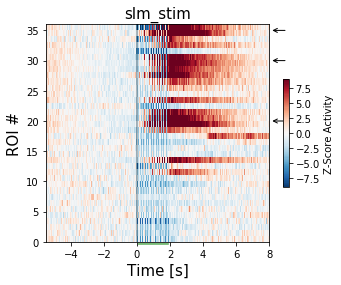

In [19]:
num_subplots = len(conditions)
n_columns = np.min([num_subplots, 3.0])
n_rows = int(np.ceil(num_subplots/n_columns))

# set imshow extent to replace x and y axis ticks/labels
plot_extent = [tvec[0], tvec[-1], 0, num_rois]

fig, ax = plt.subplots(nrows=n_rows, ncols=int(n_columns), figsize = (n_columns*5, n_rows*4))
if not isinstance(ax,np.ndarray): # this is here to make the code below compatible with indexing a single subplot object
    ax = [ax]
    
for idx, cond in enumerate(conditions):
    
    # determine subplot location index
    if n_rows == 1:
        subplot_index = idx
    else:
        subplot_index = np.unravel_index(idx, (n_rows, int(n_columns))) # turn int index to a tuple of array coordinates
    
    # plot x and y labels for first subplot
    if subplot_index == (0, 0) or subplot_index == 0 :
        ax[subplot_index].set_ylabel('ROI #', fontsize=axis_label_size)
        ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size);
    
    # plot the data
    if flag_sort_rois:
        roi_order = sorted_roi_order
    else:
        roi_order = slice(0, num_rois)
    to_plot = data_dict[cond]['ztrial_avg_data'][roi_order,:] # np.mean( data_dict[cond]['data'], axis=0) #
        
    im = utils.subplot_heatmap(ax[subplot_index], cond, to_plot, clims = clims_z, extent_=plot_extent)
    ax[subplot_index].axvline(0, color='k', alpha=0.3) # plot vertical line for time zero
    ax[subplot_index].annotate('', xy=(event_bound_ratio[0], -0.01), xycoords='axes fraction', 
                                   xytext=(event_bound_ratio[1], -0.01), 
                                   arrowprops=dict(arrowstyle="-", color='g'))
    
    for ROI_OI in interesting_rois:
        ax[subplot_index].annotate('', xy=(1.005, ROI_OI/num_rois), xycoords='axes fraction', 
                                   xytext=(1.08, ROI_OI/num_rois), 
                                   arrowprops=dict(arrowstyle="->", color='k'))
    
cbar = fig.colorbar(im, ax = ax, shrink = 0.5)
cbar.ax.set_ylabel('Z-Score Activity')

## Plot trial- and ROI-averaged traces

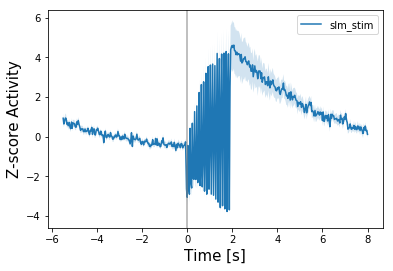

In [15]:

for cond in conditions:
    # first trial avg the data
    trial_avg = np.mean(data_dict[cond]['data'], axis=0)
    
    # z-score trial-avg data for each respective ROI
    # apply zscore function to each row of data
    app_axis = 1 
    zscore_trial_avg = np.apply_along_axis(utils.zscore_, app_axis, trial_avg, baseline_svec)
    
    # take avg/std across ROIs
    zscore_roi_trial_avg = np.mean(zscore_trial_avg, axis=0)
    zscore_roi_trial_std = np.std(zscore_trial_avg, axis=0)
     
    to_plot = np.squeeze(zscore_roi_trial_avg)
    to_plot_err = np.squeeze(zscore_roi_trial_std)/np.sqrt(num_rois)
    
    fig = sns.lineplot(tvec, to_plot)
    if flag_roi_trial_avg_errbar:
        fig.fill_between(tvec, to_plot - to_plot_err, to_plot + to_plot_err,
                     alpha=0.2) # this plots the shaded error bar
    
fig.set_ylabel('Z-score Activity', fontsize=axis_label_size)
fig.set_xlabel('Time [s]', fontsize=axis_label_size);
fig.legend(conditions);
fig.axvline(0, color='0.5', alpha=0.65) # plot vertical line for time zero

In [16]:
# # for saving behav data

# import numpy as np
# import pickle
# event_frames = {}
# event_frames['slm_stim'] = np.array([254.])

# with open(r'D:\20200410_gcamp_chrmine\vj_ofc_imageactivate_01_300_stim-009\framenumberforevents_vj_ofc_imageactivate_01_300_stim-009.pickle', 'wb') as handle:
#     pickle.dump(event_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)